In [47]:
import numpy as np
import pandas as pd
import cv2
import mahotas
import os
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage import io
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from pathlib import Path

import xgboost

In [2]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()

Number of images:  422
C:\Users\Shadow\Documents\Projets\MastereIA\DataChallenge\histopathological\exploration\..\data\input\Train\SOB_B_A-14-22549AB-100-001.png


<function skimage.io._io.show()>

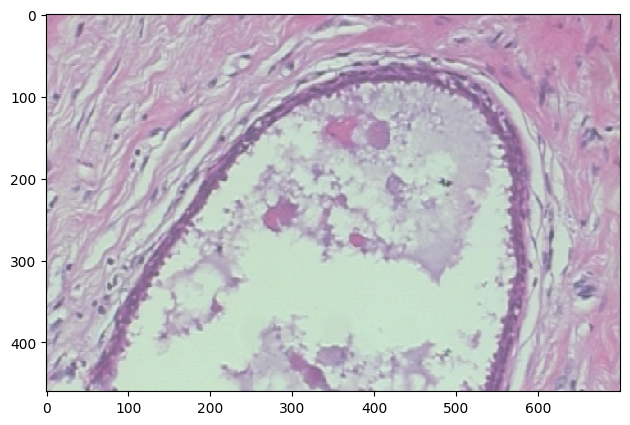

In [60]:
from skimage import io
import os

wd = os.path.join(os.getcwd(), '..')
data = os.path.join(wd, 'data', 'input')
image_train_path = os.path.join(data, 'Train')
model_path = os.path.join(wd, "data", "model")

# get images list from folder using os.listdir
images = os.listdir(path=image_train_path)
images = [image for image in images if Path(image).suffix == '.png']

# Number of images
print("Number of images: ", len(images))

# Image visualisation
print(os.path.join(image_train_path,images[0]))
io.imshow(os.path.join(image_train_path,images[0]))
io.show

In [5]:
# parameters for the features extraction
bins = 16

def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [6]:
# Compute the features
feat_histogram = []

for i in images:
    img = cv2.imread(os.path.join(image_train_path, i))  # Load image
    feat_histogram.append(fd_histogram(img))  # Append Histogram values

In [11]:
feat_histogram[0].shape

(1000,)

In [12]:
type(feat_histogram[0])

numpy.ndarray

In [30]:
feat_histogram_shaped = np.reshape(feat_histogram, (len(feat_histogram), len(feat_histogram[0])))

In [31]:
# model XGboost
model = XGBClassifier(max_depth=8, n_estimators=100, learning_rate=0.1)

(422, 1000)

In [35]:
def parse_fn(filename):
    # <BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>-<YEAR>-<SLIDE_ID>-<MAG>-<SEQ>
    parsed = filename[:-4].replace('-', '_').split('_')
    parsed.append(filename)
    return parsed

columns = ['procedure', 'class', 'type', 'magnification', 'slide', 'mag', 'seq', 'filename']

df = pd.DataFrame(list(map(parse_fn, images)), columns=columns)
label_types = df['type'].unique()
print(label_types)
print(df.head())

['A' 'F' 'PT' 'TA' 'DC' 'LC' 'MC' 'PC']
  procedure class type magnification    slide  mag  seq                        filename
0       SOB     B    A            14  22549AB  100  001  SOB_B_A-14-22549AB-100-001.png
1       SOB     B    A            14  22549AB  100  002  SOB_B_A-14-22549AB-100-002.png
2       SOB     B    A            14  22549AB  100  003  SOB_B_A-14-22549AB-100-003.png
3       SOB     B    A            14  22549AB  100  005  SOB_B_A-14-22549AB-100-005.png
4       SOB     B    A            14  22549AB  100  006  SOB_B_A-14-22549AB-100-006.png


In [51]:
label_maps = {'F':0, 'DC':1, 'PC':2, 'PT':3, 'MC':4, 'LC':5, 'A':6, 'TA':7}
df['type_id'] = df['type'].apply(lambda x: label_maps[x])

print(df.head(10))

  procedure class type magnification    slide  mag  seq                        filename  type_id
0       SOB     B    A            14  22549AB  100  001  SOB_B_A-14-22549AB-100-001.png        6
1       SOB     B    A            14  22549AB  100  002  SOB_B_A-14-22549AB-100-002.png        6
2       SOB     B    A            14  22549AB  100  003  SOB_B_A-14-22549AB-100-003.png        6
3       SOB     B    A            14  22549AB  100  005  SOB_B_A-14-22549AB-100-005.png        6
4       SOB     B    A            14  22549AB  100  006  SOB_B_A-14-22549AB-100-006.png        6
5       SOB     B    A            14  22549AB  100  013  SOB_B_A-14-22549AB-100-013.png        6
6       SOB     B    A            14  22549AB  100  014  SOB_B_A-14-22549AB-100-014.png        6
7       SOB     B    A            14  22549AB  100  015  SOB_B_A-14-22549AB-100-015.png        6
8       SOB     B    A            14  22549AB  100  018  SOB_B_A-14-22549AB-100-018.png        6
9       SOB     B    A        

In [52]:
# Step 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feat_histogram_shaped, df['type_id'], test_size=0.2, random_state=42)

In [53]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

In [54]:
clf = xgboost.XGBClassifier(objective='multi:softmax', num_class=8)

In [55]:
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)

In [56]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, num_class=8,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.75, 1],
                         'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'reg_alpha': [0, 0.1, 1], 'reg_lambda': [0, 0.1, 1],
                         'subsample': [0.5, 0.75, 1]})

In [57]:
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.75}
Best score:  0.8280070237050043


In [58]:
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Test accuracy: ", accuracy)

Test accuracy:  0.8


In [61]:
best_clf.save_model(os.path.join(model_path, 'xgb_model.bin'))

## Prediction time

In [62]:
wd = os.path.join(os.getcwd(), '..')
data = os.path.join(wd, 'data', 'input')
image_test_path = os.path.join(data, 'Test')

# Test images
images_test = os.listdir(path=image_test_path)

def parseTest_fn(filename):
    # <BIOPSY_PROCEDURE>_<ID>
    parsed = filename[:-4].split('_')
    parsed.append(filename)
    return parsed

columns = ['procedure', 'id', 'filename']

df_test = pd.DataFrame(list(map(parseTest_fn, images_test)), columns=columns)
df_test['type_id'] = 0
df_test.head()

,procedure,id,filename,type_id
0,SOB,1,SOB_1.png,0
1,SOB,10,SOB_10.png,0
2,SOB,100,SOB_100.png,0
3,SOB,101,SOB_101.png,0
4,SOB,102,SOB_102.png,0


In [69]:
# Test images
image_test_path = os.path.join(data, 'Test')
submission_path = os.path.join(wd, 'data', 'output', 'submission', 'pred_swim_20230306_2222.csv')
images_test = os.listdir(image_test_path)


# Number of images
print("Number of images for the test set: ", len(images_test))

Number of images for the test set:  207


In [65]:
def parseTest_fn(filename):
    # <BIOPSY_PROCEDURE>_<ID>
    parsed = filename[:-4].split('_')
    parsed.append(filename)
    return parsed

columns = ['procedure', 'id', 'filename']

df_test = pd.DataFrame(list(map(parseTest_fn, images_test)), columns=columns)
print(df_test.head())
print(df_test.shape)

  procedure   id     filename
0       SOB    1    SOB_1.png
1       SOB   10   SOB_10.png
2       SOB  100  SOB_100.png
3       SOB  101  SOB_101.png
4       SOB  102  SOB_102.png
(207, 3)


In [67]:
feat_histogram_test = []
for i in images_test:
    img = cv2.imread(os.path.join(image_test_path, i))  # Load image
    feat_histogram_test.append(fd_histogram(img))  # Append Histogram values

In [68]:
feat_histogram_test_shaped = np.reshape(feat_histogram_test, (len(feat_histogram_test), len(feat_histogram_test[0])))

In [71]:
y_pred_test = best_clf.predict(feat_histogram_test_shaped)+1
df_pred = pd.concat([df_test['id'], pd.Series(y_pred_test, name='type_id')], axis=1)
display(df_pred['type_id'].value_counts())
df_pred.to_csv(submission_path, index=False, header=False)

7    67
2    45
3    37
1    25
4    22
5    10
8     1
Name: type_id, dtype: int64